In [ ]:
!pip install regex

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import re

def clean_html(text):
    """Remove HTML tags and convert text to lowercase."""
    return re.sub(r'<.*?>', '', text).lower()

def process_file(input_path, output_path):
    # Open the input and output files
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        line_number = 0
        for line in infile:
            line_number += 1
            try:
                # Load the JSON object from each line
                entry = json.loads(line)

                # Clean the 'content' field
                entry['content'] = clean_html(entry['content'])

                # Remove specified keys from the dictionary
                keys_to_remove = ['id', 'title', 'media-type', 'source', 'published']
                for key in keys_to_remove:
                    entry.pop(key, None)  # Use pop to remove the key, None ensures no error if the key is missing

                # Convert the dictionary back to JSON and write it to the output file
                json.dump(entry, outfile)
                outfile.write('\n')  # Add a newline to separate JSON objects
            except json.JSONDecodeError as e:
                # Log the error and the line number
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue  # Skip this line and continue with the next

# Specify the input and output file paths
input_path = '/content/drive/My Drive/cmput_656/NER_100.jsonl'
output_path = '/content/drive/My Drive/cmput_656/clean100.jsonl'

# Process the file
process_file(input_path, output_path)

In [ ]:
import json

def process_entities(input_path):
    # Initialize lists to store entity names and mentions separately
    entities = []
    mentions = []

    # Initialize a dictionary for key-value pairs of mentions and entity names
    mention_to_entity = {}

    # Read the input JSON file
    with open(input_path, 'r') as file:
        data = json.load(file)  # Assuming the entire JSON is an array of objects

    # Process each entry in the JSON data
    for item in data:
        mention = item['mention']
        entity_name = item['predictions'][0]['entity'] if item['predictions'] else None

        # Append to the lists
        entities.append(entity_name)
        mentions.append(mention)

        # Add to the dictionary
        mention_to_entity[mention] = entity_name

    # Save the key-value pairs to a new JSON file
    with open('mention_to_entity.json', 'w') as outfile:
        json.dump(mention_to_entity, outfile, indent=4)

    # Save entities to a new file
    with open('entities.json', 'w') as outfile:
        json.dump(entities, outfile, indent=4)

    # Save mentions to a new file
    with open('mentions.json', 'w') as outfile:
        json.dump(mentions, outfile, indent=4)

# Path to the input JSON file
input_path = '/content/drive/My Drive/cmput_656/processeddata.json'

# Call the function
process_entities(input_path)

In [ ]:
import json
from collections import defaultdict

def count_entity_frequencies(entities_file, content_file, output_file):
    # Load entities from the JSON file
    with open(entities_file, 'r') as file:
        entities = json.load(file)

    # Initialize a dictionary to count entity frequencies
    frequency = defaultdict(int)

    # Read the content file and count frequencies
    with open(content_file, 'r') as file:
        for line in file:
            content_data = json.loads(line)['content'].lower()  # Convert content to lowercase to ensure case-insensitive matching
            for entity in entities:
                # Count the number of times the lowercase entity appears in the content
                frequency[entity] += content_data.count(entity.lower())

    # Save the frequency data to a JSON file
    with open(output_file, 'w') as file:
        json.dump(frequency, file, indent=4)

# File paths
entities_file = '/content/drive/My Drive/cmput_656/mentions.json'
content_file = '/content/drive/My Drive/cmput_656/clean100.jsonl'
output_file = '/content/drive/My Drive/cmput_656/frequencies.json'

# Run the function
count_entity_frequencies(entities_file, content_file, output_file)

In [ ]:
import json
from collections import defaultdict

def load_json_file(file_path):
    """Utility function to load a JSON file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def count_entity_frequencies(entities, content_file):
    """Count the frequency of each entity within the content file."""
    frequency = defaultdict(int)
    with open(content_file, 'r') as file:
        for line in file:
            content_data = json.loads(line)['content'].lower()
            for entity in entities:
                frequency[entity] += content_data.count(entity.lower())
    return frequency

def sort_frequencies(frequencies):
    """Sort frequencies dictionary by value in descending order."""
    return {k: v for k, v in sorted(frequencies.items(), key=lambda item: item[1], reverse=True)}

def match_entities_with_mentions(sorted_frequencies, entity_mentions):
    """Match sorted entities with their mentions."""
    matched_data = []
    for entity, count in sorted_frequencies.items():
        mention = entity_mentions.get(entity, "No mention found")
        matched_data.append({'entity': entity, 'mention': mention, 'count': count})
    return matched_data

def main(entities_file, content_file, entity_mention_file, output_file):
    entities = load_json_file(entities_file)
    entity_mentions = load_json_file(entity_mention_file)

    frequencies = count_entity_frequencies(entities, content_file)
    sorted_frequencies = sort_frequencies(frequencies)

    matched_results = match_entities_with_mentions(sorted_frequencies, entity_mentions)

    # Save the matched results to a JSON file
    with open(output_file, 'w') as file:
        json.dump(matched_results, file, indent=4)

# File paths
entities_file = '/content/drive/My Drive/cmput_656/mentions.json'
content_file = '/content/drive/My Drive/cmput_656/clean100.jsonl'
entity_mention_file = '/content/drive/My Drive/cmput_656/mention_to_entity.json'
output_file = '/content/drive/My Drive/cmput_656/sorted_matched_entities.json'

# Run the function
main(entities_file, content_file, entity_mention_file, output_file)

In [ ]:
import json
import difflib

def calculate_overlap(entity, mention):
    """
    Calculate the percentage overlap between the entity abbreviation and the full mention.
    """
    # Normalize strings by lowering case
    entity_normalized = entity.lower()
    mention_normalized = mention.lower()

    # Create a sequence matcher
    s = difflib.SequenceMatcher(None, entity_normalized, mention_normalized)

    # Calculate the number of matching characters
    match = sum(n for i, j, n in s.get_matching_blocks())

    # Calculate the average length of the entity and the mention
    average_length = (len(entity_normalized) + len(mention_normalized)) / 2

    # Calculate the percentage overlap based on the average length
    percentage_overlap = (match / average_length) * 100
    return percentage_overlap

def process_data(file_path):
    # Load data from a JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # List to store results
    results = []

    # Process each entry in the data
    for entry in data:
        overlap_percentage = calculate_overlap(entry['entity'], entry['mention'])
        results.append({
            "entity": entry['entity'],
            "mention": entry['mention'],
            "overlap_percentage": overlap_percentage
        })
        print(f"Overlap between '{entry['entity']}' and '{entry['mention']}': {overlap_percentage:.2f}%")

    # Save results to a JSON file
    with open('/content/drive/My Drive/cmput_656/overlap_results.json', 'w') as outfile:
        json.dump(results, outfile, indent=4)


# Assuming the data is stored in 'data.json'
file_path = '/content/drive/My Drive/cmput_656/sorted_matched_entities.json'
process_data(file_path)

Overlap between 'un' and 'United Nations': 25.00%
Overlap between 'ani' and 'Asian News International': 22.22%
Overlap between 'indi' and 'Division of Indi': 40.00%
Overlap between 'ny' and 'New York City': 26.67%
Overlap between 'sec' and 'U.S. Securities and Exchange Commission': 14.29%
Overlap between 'labor' and 'Australian Labor Party': 37.04%
Overlap between 'eric' and 'Jessie James Decker': 17.39%
Overlap between 'eu' and 'European Union': 25.00%
Overlap between 'chin' and 'Chin people': 53.33%
Overlap between 'sun' and 'Sun Microsystems': 31.58%
Overlap between 'turnbull' and 'Malcolm Turnbull': 66.67%
Overlap between 'ies' and 'Indian Economic Service': 23.08%
Overlap between 'alp' and 'Australian Labor Party': 24.00%
Overlap between 'state' and 'U.S. state': 66.67%
Overlap between 'clark' and 'Clark': 100.00%
Overlap between 'europe' and 'Europe': 100.00%
Overlap between 'larijani' and 'Mohammad-Javad Larijani': 51.61%
Overlap between 'leah' and 'Leah': 100.00%
Overlap betwee

In [ ]:
pip install matplotlib

In [1]:
from google.colab import files

uploaded = files.upload()

Saving processeddata.json to processeddata.json


                 mention  confidence_score
938        leslie berlin         12.722016
856        shaggy 2 dope         12.713063
36          meryl streep         12.702667
50         harvey keitel         12.700891
937         robert noyce         12.682679
...                  ...               ...
989         ryan smolkin        -12.153287
1080  daniela lusuriello        -12.154161
67             two sizes        -12.196137
783   arthur hapgood sr.        -12.211156
851                forab        -12.532015

[1287 rows x 2 columns]


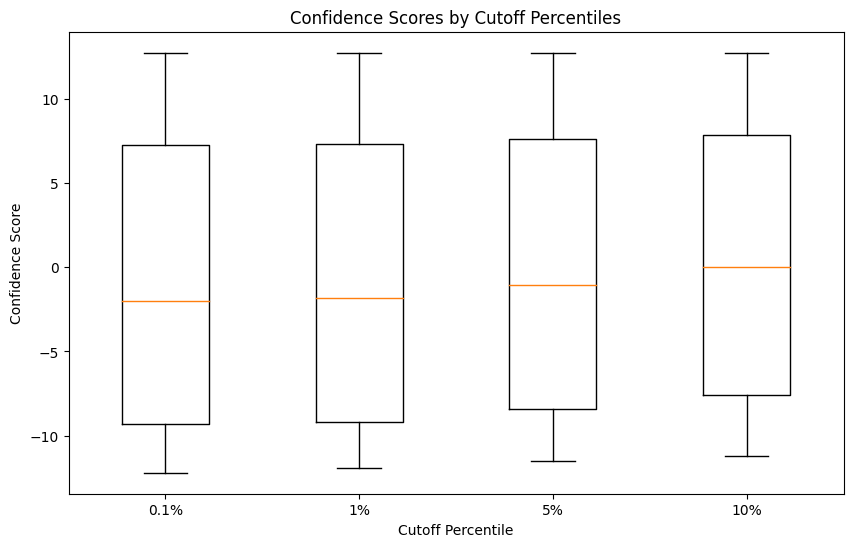

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Assuming the file name is 'data.json'
file_name = next(iter(uploaded.keys()))
data = json.load(open(file_name))

# Extract data and convert confidence scores to float
df = pd.DataFrame({
    "mention": [item["mention"] for item in data],
    "confidence_score": [float(pred["predictions"][0]["confidence_score"]) for pred in data]
})

# Sort the DataFrame by confidence scores in descending order
df = df.sort_values(by='confidence_score', ascending=False)

# Display the sorted DataFrame to verify data
print(df)

# Define cutoff points as percentiles
cutoffs = [0.1, 1, 5, 10]
cutoff_values = [df['confidence_score'].quantile(q / 100) for q in cutoffs]

# Prepare the data for the box plot, filtering by the cutoff points
data_to_plot = [df[df['confidence_score'] >= cutoff]['confidence_score'] for cutoff in cutoff_values]

# Creating the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=[f"{cutoff}%" for cutoff in cutoffs])
plt.title('Confidence Scores by Cutoff Percentiles')
plt.ylabel('Confidence Score')
plt.xlabel('Cutoff Percentile')
plt.show()

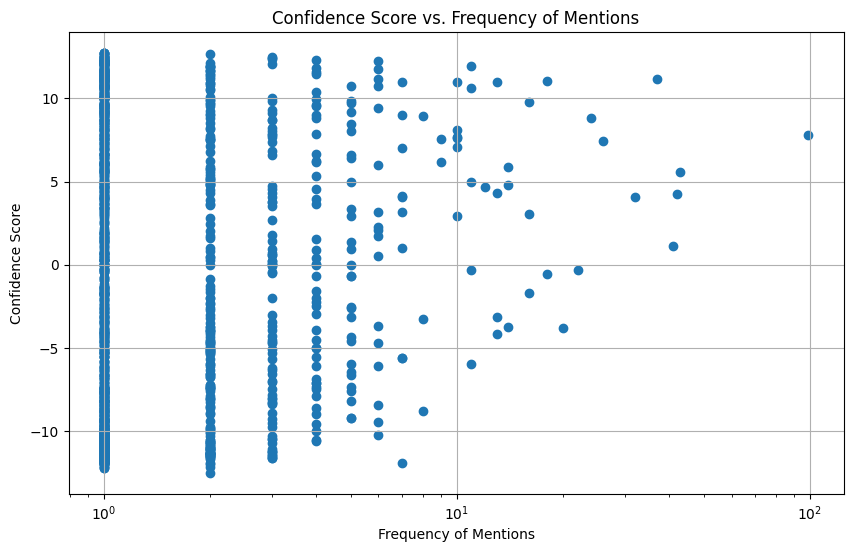

<Figure size 1000x600 with 0 Axes>

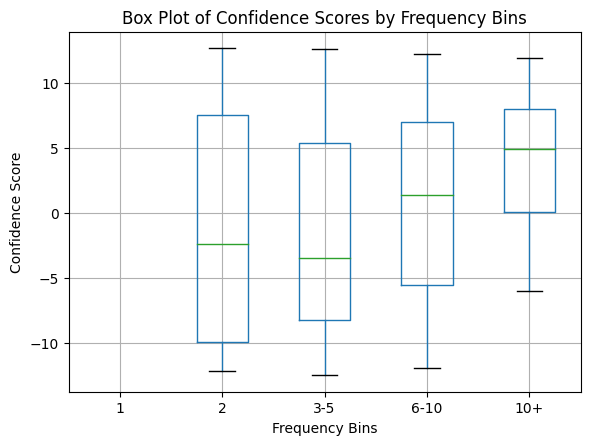

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json

def load_confidence_scores(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Normalize and create a DataFrame
    records = [{'mention': d['mention'], 'entity': pred['entity'], 'confidence_score': float(pred['confidence_score'])}
               for d in data for pred in d['predictions']]
    return pd.DataFrame(records)

def load_frequencies(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(list(data.items()), columns=['mention', 'frequency'])

def main(confidence_file_path, frequency_file_path):
    # Load data
    confidence_df = load_confidence_scores(confidence_file_path)
    frequencies_df = load_frequencies(frequency_file_path)

    # Merge the DataFrames
    merged_df = pd.merge(confidence_df, frequencies_df, on='mention')

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['frequency'], merged_df['confidence_score'])
    plt.title('Confidence Score vs. Frequency of Mentions')
    plt.xlabel('Frequency of Mentions')
    plt.ylabel('Confidence Score')
    plt.xscale('log')  # Using a log scale for frequency if there's a wide range
    plt.grid(True)
    plt.show()

    # Preparing data for box plot
    bins = [0, 1, 2, 5, 10, 100]  # Adjust bins as necessary
    labels = ['1', '2', '3-5', '6-10', '10+']
    merged_df['frequency_bins'] = pd.cut(merged_df['frequency'], bins=bins, labels=labels, right=False)

    # Box plot
    plt.figure(figsize=(10, 6))
    merged_df.boxplot(column='confidence_score', by='frequency_bins')
    plt.title('Box Plot of Confidence Scores by Frequency Bins')
    plt.suptitle('')  # Remove the automatic 'Figure Title' added by Pandas
    plt.xlabel('Frequency Bins')
    plt.ylabel('Confidence Score')
    plt.show()

# Replace 'path_to_confidence_scores.json' and 'path_to_frequencies.json' with your actual file paths
main('/content/drive/My Drive/cmput_656/processeddata.json','/content/drive/My Drive/cmput_656/frequencies.json')

In [12]:
!pip install matplotlib

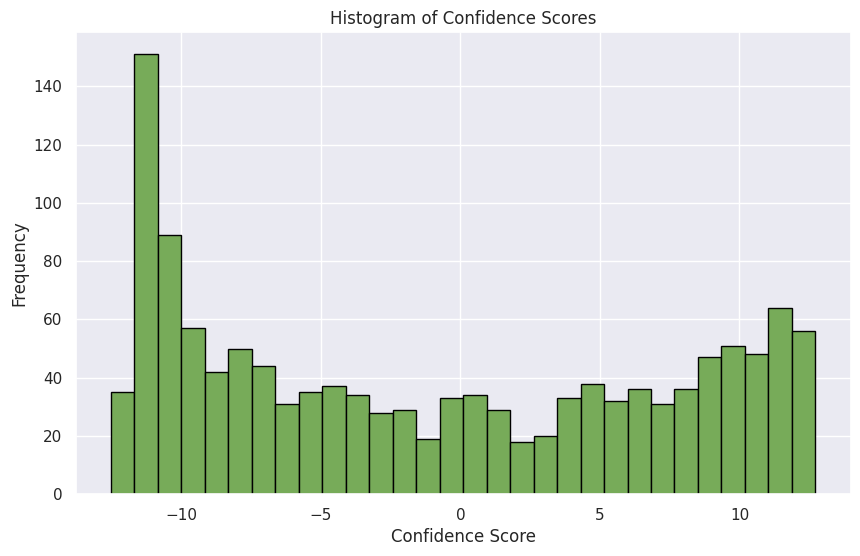

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import json
# Importing required Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting a figure size for all the plots we shall be drawing in this kernel:
sns.set(rc={"figure.figsize": (6, 6)})

def load_confidence_scores(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Normalize and create a DataFrame
    records = [{'mention': d['mention'], 'entity': pred['entity'], 'confidence_score': float(pred['confidence_score'])}
               for d in data for pred in d['predictions']]
    return pd.DataFrame(records)

def create_histogram(dataframe, column='confidence_score'):
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe[column], bins=30, color='#77ab59', edgecolor='black')
    plt.title('Histogram of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def main(confidence_file_path):
    # Load data
    confidence_df = load_confidence_scores(confidence_file_path)

    # Create histogram
    create_histogram(confidence_df)

# Replace 'path_to_confidence_scores.json' with your actual file path
main('/content/drive/My Drive/cmput_656/processeddata.json')

In [15]:
!pip install pandas

In [17]:
import json
import pandas as pd

def load_data(confidence_file, frequency_file):
    # Load confidence scores
    with open(confidence_file, 'r') as file:
        confidence_data = json.load(file)

    # Normalize confidence data into a list of dictionaries
    confidence_records = [
        {'mention': item['mention'], 'type': item['type'], 'entity': pred['entity'], 'confidence_score': pred['confidence_score']}
        for item in confidence_data for pred in item['predictions']
    ]

    # Load frequency data
    with open(frequency_file, 'r') as file:
        frequency_data = json.load(file)

    # Convert frequency data into a DataFrame
    frequency_df = pd.DataFrame(list(frequency_data.items()), columns=['mention', 'frequency'])

    # Convert confidence data into a DataFrame
    confidence_df = pd.DataFrame(confidence_records)

    # Merge the two DataFrames on the mention column
    merged_df = pd.merge(confidence_df, frequency_df, on='mention', how='left')

    # Fill NaN frequencies with 0 (assumes no frequency recorded means not mentioned)
    merged_df['frequency'].fillna(0, inplace=True)

    return merged_df

def save_to_file(dataframe, output_file):
    # Convert DataFrame to JSON and save to file
    dataframe.to_json(output_file, orient='records', lines=True)

# Paths to the data files
confidence_file_path = '/content/drive/My Drive/cmput_656/processeddata.json'
frequency_file_path = '/content/drive/My Drive/cmput_656/frequencies.json'
output_file_path = '/content/drive/My Drive/cmput_656/graphdata.json'

# Processing the data
merged_data = load_data(confidence_file_path, frequency_file_path)

# Saving the combined data to a file
save_to_file(merged_data, output_file_path)

print("Data has been merged and saved successfully.")

Data has been merged and saved successfully.


In [26]:
def fix_json(file_path):
    # Read the original file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # This will hold the corrected version of the file content
    corrected_content = []

    # Process each line
    for i, line in enumerate(lines):
        # Strip whitespace for a clean check
        stripped_line = line.strip()
        # Add a comma at the end of the line if it's not empty and it is a valid JSON closing
        if stripped_line and stripped_line.endswith('}'):
            # Add a comma only if it's not the last JSON object
            if i < len(lines) - 1:
                corrected_content.append(stripped_line + ',\n')
            else:
                corrected_content.append(stripped_line + '\n')
        else:
            corrected_content.append(line)

    # Write the corrected content to a new file
    with open('corrected_file.json', 'w') as corrected_file:
        corrected_file.write('[\n' + ''.join(corrected_content) + ']')

# Specify your file path
file_path = '/content/drive/My Drive/cmput_656/graphdata.json'
fix_json(file_path)

In [29]:
from google.colab import files

uploaded = files.upload()
filename = next(iter(uploaded.keys()))

Saving corrected_file.json to corrected_file (1).json


Average Confidence Scores by Frequency:
frequency
1     -1.151858
2     -1.982845
3     -1.473767
4      0.164201
5      0.116124
6      1.678541
7      1.626945
8     -1.053685
9      6.874566
10     7.398745
11     4.255147
12     4.688967
13     1.995918
14     2.317412
16     3.690966
18     5.223286
20    -3.783960
22    -0.328244
24     8.823270
26     7.415379
32     4.072385
37    11.189518
41     1.142284
42     4.255557
43     5.577144
99     7.805722
Name: confidence_score, dtype: float64


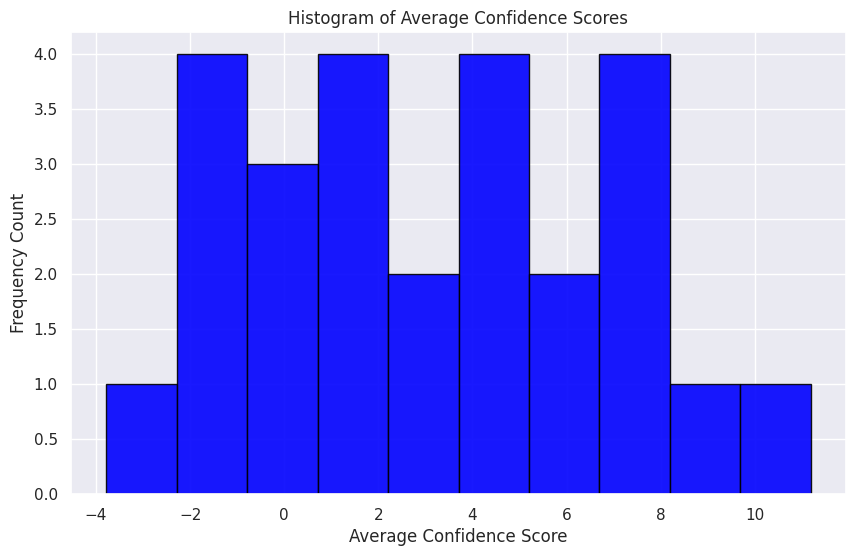

In [43]:
import pandas as pd
import json

# Assuming 'filename' is your JSON file's name
filename = '/content/drive/My Drive/cmput_656/corrected_file.json'  # Make sure to replace this with your actual file name
with open(filename, 'r') as file:
    data = json.load(file)  # Load the JSON data from the file

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Convert the 'confidence_score' from string to numeric
df['confidence_score'] = pd.to_numeric(df['confidence_score'])

# Group by 'frequency' and calculate the mean of 'confidence_score'
average_confidence = df.groupby('frequency')['confidence_score'].mean()

# Print the DataFrame with averages to verify data
print("Average Confidence Scores by Frequency:")
print(average_confidence)

# Plotting the histogram of average confidence scores
plt.figure(figsize=(10, 6))  # Set the figure size for the histogram
plt.hist(average_confidence, bins=10, alpha=0.9, color='blue', edgecolor='black')
plt.title('Histogram of Average Confidence Scores')
plt.xlabel('Average Confidence Score')
plt.ylabel('Frequency Count')
plt.grid(True)  # Add a grid for better readability
plt.show()

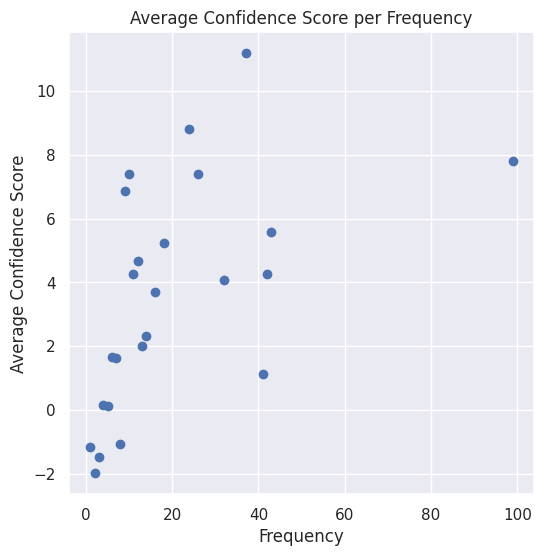

In [46]:
import matplotlib.pyplot as plt

# Extract the frequency and confidence score pairs
frequencies = []
confidence_scores = []
for freq, score in data.items():
    frequencies.append(freq)
    confidence_scores.append(score)

# Create the scatter plot
plt.scatter(frequencies, confidence_scores)

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Average Confidence Score')
plt.title('Average Confidence Score per Frequency')

# Show the plot
plt.show()

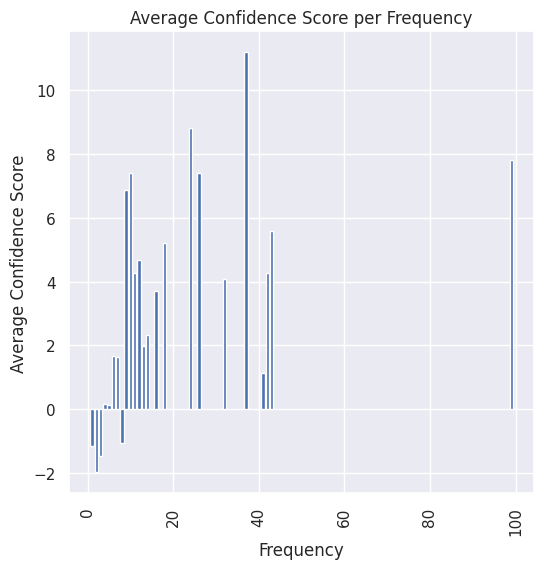

In [47]:
import matplotlib.pyplot as plt

# Extract the frequency and confidence score pairs
frequencies = []
confidence_scores = []
for freq, score in data.items():
    frequencies.append(freq)
    confidence_scores.append(score)

# Create the bar graph
plt.bar(frequencies, confidence_scores)

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Average Confidence Score')
plt.title('Average Confidence Score per Frequency')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

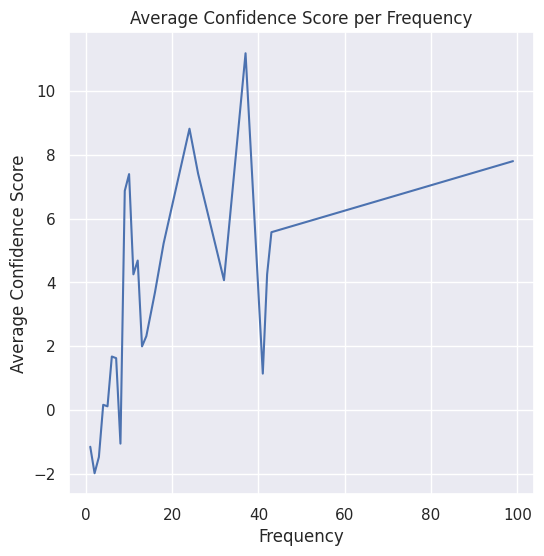

In [48]:
import matplotlib.pyplot as plt

# Extract the frequency and confidence score pairs
frequencies = []
confidence_scores = []
for freq, score in data.items():
    frequencies.append(freq)
    confidence_scores.append(score)

# Sort the data by frequency
sorted_data = sorted(zip(frequencies, confidence_scores))
sorted_frequencies, sorted_confidence_scores = zip(*sorted_data)

# Create the slope graph
plt.plot(sorted_frequencies, sorted_confidence_scores)

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Average Confidence Score')
plt.title('Average Confidence Score per Frequency')

# Show the plot
plt.show()

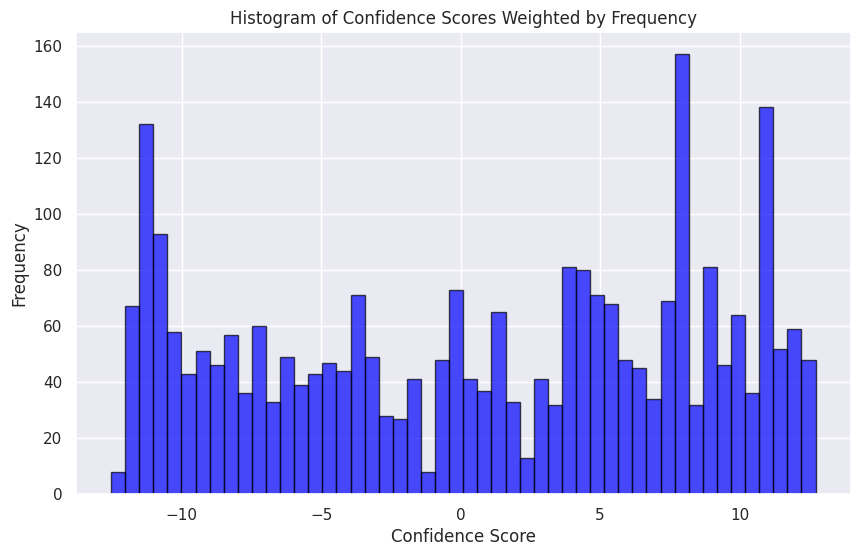

In [39]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(df['confidence_score'], bins=50, weights=df['frequency'], alpha=0.7, color='blue', edgecolor='black')

# Adding title and labels
plt.title('Histogram of Confidence Scores Weighted by Frequency')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()